# Host perspective: clean logs

In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pd.set_option('display.max_rows', 4)

In [4]:
import sys
sys.path.append("..")

from tools import read_host_logs

## Parameters

In [5]:
#parameters
tmp_data_path = "../tmp_data/"

## Set up output data dir

In [6]:
tmp_data_path = Path(tmp_data_path)
!mkdir -pv {str(tmp_data_path)}

## Read log files

In [7]:
%%time

raw_host_logs = read_host_logs('../host_logs/', '*.tar.gz')
display(raw_host_logs)

,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
Date,,,,,,,,,,
2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-04-07 09:53:57,47,5.773438,1,0.0,184.894531,neshve06,"bmtest,veexpress,vequeue,veinteractive",3.378906,0.617188,16.0
2020-04-07 09:53:57,47,6.820312,1,0.0,183.847656,neshve07,"bmtest,veexpress,vequeue,veinteractive",3.812500,0.183594,16.1


CPU times: user 42 s, sys: 2.05 s, total: 44 s
Wall time: 44.2 s


## Keep only login and batch production nodes

Drop the `ve*` vector, and the experimental `cltestque` and `clinteractive` only nodes.

In [8]:
display(raw_host_logs["QueueName"].unique())

array(['clbigmem', 'clmedium', 'clmedium,cltestque', 'cllong', 'clfo2',
       'clexpress', 'cltestque,clinteractive', 'cltestque',
       'bmtest,veexpress,vequeue,veinteractive', 'nan', 'feque',
       'bmtest,veexpress,vequeueb,veinteractive', 'cltestque,clmedium'],
      dtype=object)

In [9]:
display(raw_host_logs["ExecutionHost"].unique())

array(['neshcl218', 'neshcl219', 'neshcl220', 'neshcl221', 'neshcl222',
       'neshcl223', 'neshcl228', 'neshcl229', 'neshcl233', 'neshcl234',
       'neshcl235', 'neshcl236', 'neshcl237', 'neshcl238', 'neshcl239',
       'neshcl242', 'neshcl243', 'neshcl244', 'neshcl245', 'neshcl247',
       'neshcl248', 'neshcl251', 'neshcl254', 'neshcl258', 'neshcl259',
       'neshcl262', 'neshcl263', 'neshcl264', 'neshcl267', 'neshcl270',
       'neshcl271', 'neshcl272', 'neshcl273', 'neshcl274', 'neshcl275',
       'neshcl276', 'neshcl277', 'neshcl278', 'neshcl279', 'neshcl281',
       'neshcl283', 'neshcl284', 'neshcl285', 'neshcl288', 'neshcl291',
       'neshcl295', 'neshcl296', 'neshcl297', 'neshcl298', 'neshcl301',
       'neshcl302', 'neshcl303', 'neshcl304', 'neshcl306', 'neshcl307',
       'neshcl308', 'neshcl309', 'neshcl311', 'neshcl313', 'neshcl314',
       'neshcl315', 'neshcl316', 'neshcl317', 'neshcl319', 'neshcl320',
       'neshcl321', 'neshcl322', 'neshcl323', 'neshcl325', 'nesh

In [10]:
# Identify batch production nodes.
keep_these_batch_classes = 'clbigmem|clmedium|cllong|clfo2|clexpress|feque'
mask_by_batch_class = raw_host_logs['QueueName'].str.contains(keep_these_batch_classes)

In [11]:
# Identify login nodes.
keep_these_hosts = 'nesh-fe2-adm|nesh-fe1-adm|nesh-fe3-adm|nesh-fe0-adm'
mask_by_host = raw_host_logs['ExecutionHost'].str.contains(keep_these_hosts)

In [12]:
host_logs = raw_host_logs[ mask_by_batch_class | mask_by_host ]

Note to myself: Always select rows via `.str.contains()` and not via `.isin()`. The latter is an equivalence method and nodes allocated to more than one batch class, e.g. `clmedium,cltestque` will be omitted.

In [13]:
print(f"dropped {len(raw_host_logs) - len(host_logs)} rows")

dropped 113402 rows


In [14]:
print("eliminated thte following QueueNames:")
display(set(raw_host_logs["QueueName"]) - set(host_logs["QueueName"]))

eliminated thte following QueueNames:


{'bmtest,veexpress,vequeue,veinteractive',
 'bmtest,veexpress,vequeueb,veinteractive',
 'cltestque',
 'cltestque,clinteractive'}

In [15]:
print("eliminated the following ExecutionsHosts:")
display(set(raw_host_logs["ExecutionHost"]) - set(host_logs["ExecutionHost"]))

eliminated the following ExecutionsHosts:


{'neshcl342',
 'neshve00',
 'neshve01',
 'neshve02',
 'neshve03',
 'neshve04',
 'neshve05',
 'neshve06',
 'neshve07'}

## Fix column names for front ends

Something is wrong with memory log entries for the login nodes. Unfortunately, the `qstat` tool is not documented well enough and the code not available. For the analysis presented here, we swap `Free_Mem1` and `Used_Mem1` for the `nesh-fe?` nodes.

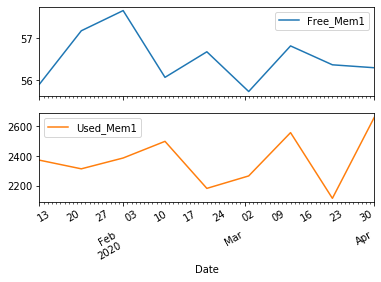

In [16]:
fe_hosts = host_logs.reset_index().set_index(["Date", "ExecutionHost"]).unstack().filter(like="nesh-fe").stack().reset_index()
fe_hosts[["Free_Mem1", "Used_Mem1"]].groupby(fe_hosts["Date"]).sum().resample("10D").min().plot(subplots=True);

_**Interpretation:** The baseline memory use of the `nesh-fe*` nodes is much more compatible with a 10-day minimum of 50 GB (or 12.5 GB / node) than the assumption that at the least busy time, all four `nesh-fe*` nodes had a memory use of 2400GB.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x139fef1d0>,
      dtype=object)

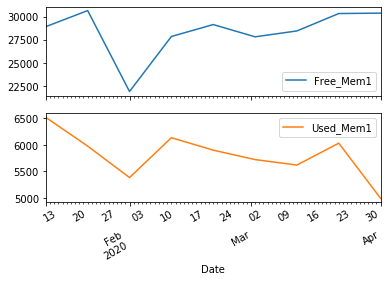

In [17]:
host_logs.reset_index()[["Free_Mem1", "Used_Mem1"]].groupby(host_logs.reset_index()["Date"]).sum().resample("10D").min().plot(subplots=True)

_**Interpretation:** For the whole cluster, this is different and the reported free mem looks plausible._

In [18]:
host_logs = host_logs.reset_index()

In [19]:
tmp_new_used_mem = host_logs.loc[host_logs["ExecutionHost"].str.contains("nesh-fe"), "Free_Mem1"]
tmp_new_free_mem = host_logs.loc[host_logs["ExecutionHost"].str.contains("nesh-fe"), "Used_Mem1"]
host_logs.loc[host_logs["ExecutionHost"].str.contains("nesh-fe"), "Free_Mem1"] = tmp_new_free_mem
host_logs.loc[host_logs["ExecutionHost"].str.contains("nesh-fe"), "Used_Mem1"] = tmp_new_used_mem

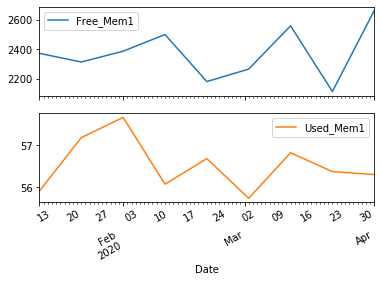

In [20]:
fe_hosts = host_logs.reset_index().set_index(["Date", "ExecutionHost"]).unstack().filter(like="nesh-fe").stack().reset_index()
fe_hosts[["Free_Mem1", "Used_Mem1"]].groupby(fe_hosts["Date"]).sum().resample("10D").min().plot(subplots=True);

In [21]:
host_logs

,Date,Free_CPUs,Free_Mem1,Used_CPUs,Cpu,Used_Mem1,ExecutionHost,QueueName,Free_Swap1,Used_Swap1,Load
0,2020-01-12 18:17:31,0,349.402344,32,32.0,33.308594,neshcl218,clbigmem,NaN,NaN,NaN
1,2020-01-12 18:17:31,0,302.101562,32,32.0,80.609375,neshcl219,clbigmem,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2206619,2020-04-07 09:53:57,63,736.996094,1,0.0,29.714844,nesh-fe2-adm,nan,0.085938,3.910156,0.4
2206620,2020-04-07 09:53:57,63,752.734375,1,1.0,13.976562,nesh-fe3-adm,nan,1.750000,2.246094,1.0


## Save to parquet

In [22]:
host_logs.to_parquet(tmp_data_path / "host_logs.prq", compression="gzip")

In [23]:
%%time

host_logs_reread = pd.read_parquet(tmp_data_path / "host_logs.prq")

CPU times: user 2.51 s, sys: 128 ms, total: 2.64 s
Wall time: 2.65 s
